In [55]:
import torch
device = torch.device('cuda')

In [56]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Loading Dataset

In [57]:
df_train = pd.read_csv('fashion-mnist_train.csv')
df_test = pd.read_csv('fashion-mnist_test.csv')

In [58]:
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
df_train.shape

(60000, 785)

## Visualizing 

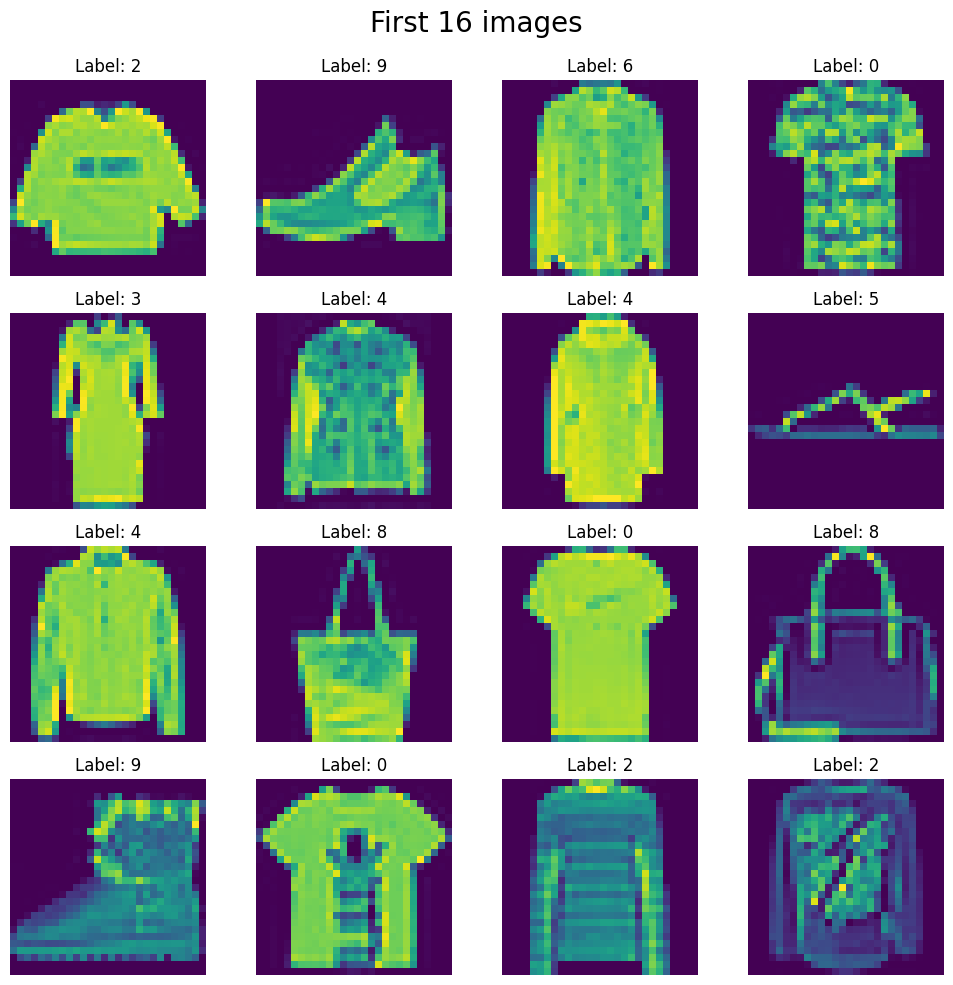

In [60]:
fig, axes = plt.subplots(4, 4, figsize = (10, 10))
fig.suptitle("First 16 images", fontsize = 20)

for i, ax in enumerate(axes.flat):
    img = df_train.iloc[i, 1:].values.reshape(28, 28)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Label: {df_train.iloc[i, 0]}")
    
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()


In [61]:
X_train = df_train.iloc[:, 1:].reset_index(drop=True)
y_train = df_train.iloc[:, 0].reset_index(drop=True)

X_test = df_test.iloc[:, 1:].reset_index(drop=True)
y_test = df_test.iloc[:, 0].reset_index(drop=True)

# Applying Transformations required by ResNet18

In [62]:
from torchvision.transforms import transforms

In [64]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [19]:
pip install Pillow



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Using Dataset class

In [65]:
from PIL import Image
import numpy as np

class Data(Dataset):

    def __init__(self, X, y, transforms):
        self.X = X
        self.y = y
        self.transforms = transforms

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        image = self.X[index].reshape(28, 28)

        image = image.astype(np.uint8)
        
        # change black&white to color and change position of channel (H,W,C) -> (C,H,W)
        image = np.stack([image]*3, axis = -1)

        image = Image.fromarray(image)

        image = self.transforms(image)

        return image, torch.tensor(self.y[index], dtype=torch.long)



In [66]:
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()

Data_train = Data(X_train_np, y_train_np, transforms = preprocess,)
Data_test = Data(X_test.to_numpy(), y_test.to_numpy(), transforms = preprocess)

In [67]:
data_loader_train = DataLoader(Data_train, batch_size=64, shuffle=True, pin_memory=True)
data_loader_test = DataLoader(Data_test, batch_size=64, shuffle=True, pin_memory=True)

# Training Pipeline

## fetching pretrained model

In [68]:
import torch
resnet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

Using cache found in C:\Users\Obliv/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\Obliv\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Obliv\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [69]:
resnet18.fc

Linear(in_features=512, out_features=1000, bias=True)

In [70]:
for param in resnet18.parameters():
    param.requires_grad = False

## Model Initialization

We keep freeze the parameters of the convulational layer and only train the fully connected layers i.e the Classifier network

In [72]:
resnet18.fc = nn.Sequential(
    nn.Linear(512, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 10)
)

In [73]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [80]:
learning_rate = 0.0001
epochs = 50

In [81]:
resnet18.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.fc.parameters(), lr = learning_rate, weight_decay=1e-4)

## Training loop

In [82]:
for epoch in range(epochs):
    resnet18.train()
    epoch_loss = 0

    for batch_X, batch_y in data_loader_train:
        
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        y_pred_batch = resnet18(batch_X)

        loss = loss_function(y_pred_batch, batch_y)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss/len(data_loader_train)
    print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')


Epoch: 1 , Loss: 1.0062617181079474
Epoch: 2 , Loss: 0.7293129845468729
Epoch: 3 , Loss: 0.6257126838413637
Epoch: 4 , Loss: 0.5606272176130495
Epoch: 5 , Loss: 0.5203300967717222
Epoch: 6 , Loss: 0.49456585096969785
Epoch: 7 , Loss: 0.4731139993743856
Epoch: 8 , Loss: 0.4586541388811333
Epoch: 9 , Loss: 0.4466902467487717
Epoch: 10 , Loss: 0.43614881366554864
Epoch: 11 , Loss: 0.42628219259827377
Epoch: 12 , Loss: 0.41619662062000873
Epoch: 13 , Loss: 0.4082666058212455
Epoch: 14 , Loss: 0.4030203974323232
Epoch: 15 , Loss: 0.3936734440516053
Epoch: 16 , Loss: 0.3892942841595678
Epoch: 17 , Loss: 0.38269353808878837
Epoch: 18 , Loss: 0.38239499206926775
Epoch: 19 , Loss: 0.3732337398188455
Epoch: 20 , Loss: 0.37189906514656823
Epoch: 21 , Loss: 0.36359122657636084
Epoch: 22 , Loss: 0.35778706985464226
Epoch: 23 , Loss: 0.35383653184021713
Epoch: 24 , Loss: 0.3548695359355224
Epoch: 25 , Loss: 0.3486808051845666
Epoch: 26 , Loss: 0.34498360986585047
Epoch: 27 , Loss: 0.3355818126819281

# Model Evaluation

## Evaluation on test data

In [83]:
resnet18.eval()

total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in data_loader_test:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = resnet18(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.8866


## Evaluation on train data

In [84]:
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in data_loader_train:

    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = resnet18(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.9253666666666667
